# Web Scraping for Indeed.com and Predicting Salaries

## Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Model evaluation requirements

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust **one of your models** to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.


### Bonus Problems

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

## Scraping job listings from Indeed.com

In [1]:
# Import packages 

import requests
import numpy as np
import bs4
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
import time 
import random
import csv
import datetime
import glob
import re
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pprint

In [2]:
# Sample URL
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=20"

# Request job search results from sample page
r = requests.get(URL)
soup = BeautifulSoup(r.text, 'html.parser')

# Count job search results from sample page
len(soup.find_all('div', class_='job_seen_beacon'))

15

*I've used the inspect tool in Chrome to identify ('table', class_='job_seen_beacon') as the template for each new job produced by an Indeed search. There are 15 jobs per page. There seem to be very few jobs with a salary range.*

In [3]:
# Prettify and review a single job result
prettyHTML = soup.find_all('div', class_='job_seen_beacon')[0].prettify() 
pprint.pprint(prettyHTML)

('<div class="job_seen_beacon">\n'
 ' <table cellpadding="0" cellspacing="0" class="jobCard_mainContent '
 'big6_visualChanges" role="presentation">\n'
 '  <tbody>\n'
 '   <tr>\n'
 '    <td class="resultContent">\n'
 '     <div class="heading4 color-text-primary singleLineTitle '
 'tapItem-gutter">\n'
 '      <h2 class="jobTitle jobTitle-color-purple">\n'
 '       <span title="Data Scientist">\n'
 '        Data Scientist\n'
 '       </span>\n'
 '      </h2>\n'
 '     </div>\n'
 '     <div class="heading6 company_location tapItem-gutter companyInfo">\n'
 '      <span class="companyName">\n'
 '       Dopple\n'
 '      </span>\n'
 '      <div class="companyLocation">\n'
 '       Remote in New York, NY\n'
 '      </div>\n'
 '     </div>\n'
 '     <div class="heading6 tapItem-gutter metadataContainer noJEMChips '
 'salaryOnly">\n'
 '      <div class="metadata">\n'
 '       <div class="attribute_snippet">\n'
 '        <svg aria-hidden="true" aria-label="Job type" fill="none" '
 'height="13" 

## Write functions to extract each items from a job listing

In [4]:
# Save a sample job to test functions on - it's unlikely that this will be well poplated with data
result=soup.find_all('div', class_='job_seen_beacon')[3]

In [5]:
# Extraction function definitions

def extract_location_from_result(result):
    try:
        j_location = result.find('div', attrs={'class':'companyLocation'}).text.strip()
    except:
        j_location = np.nan         
    return j_location

def extract_employer_from_result(result):
    try:
        j_employer = result.find('span', attrs={'class':'companyName'}).text.strip()
    except:
        j_employer = np.nan         
    return j_employer

def extract_title_from_result(result):
    try:
        j_title = result.find('h2', attrs={'class':'jobTitle jobTitle-color-purple'}).text.strip().title()
    except:
        j_title = np.nan         
    return j_title

def extract_salary_from_result(result):
    try:
        j_salary = result.find('div', attrs={'class':'salary-snippet'}).text.strip()
    except:
        j_salary = np.nan         
    return j_salary

def extract_summary_from_result(result):
    try:
        j_summary = result.find('div', attrs={'class':'job-snippet'}).text.strip()
    except:
        j_summary = np.nan         
    return j_summary

def extract_employer_rating_from_result(result):
    try:
        j_employer_rating = result.find('span', attrs={'aria-hidden':True}).text.strip()
    except:
        j_employer_rating = np.nan         
    return j_employer_rating
        

In [6]:
#Print function results from a sample job card 

print('Title:',extract_title_from_result(result))
print('Salary:',extract_salary_from_result(result))
print('Location:',extract_location_from_result(result))
print('Employer:',extract_employer_from_result(result))
print('Employer rating:',extract_employer_rating_from_result(result))
print('Summary:',extract_summary_from_result(result))

Title: Data Scientist - Global Health
Salary: nan
Location: New York, NY 10017 (Tudor City area)
Employer: System
Employer rating: nan
Summary: Collaborate with researchers and data scientists in global health to design and build better ways of linking data and knowledge.


*Now I have this working for one job, it's time to scale it up.*

## Construct a function to collect results from multiple cities and starting points. 

In [7]:
#Define job scrape function 

def scrape_jobs(scrape_dict):
    """Function designed to scrape jobs from Indeed.com
    
    Takes an input parameter dictionary in the form:
    
    {'num_pages' : 10,
     'roles' : ['data_scientist','data_analyst'],
     'cities' : ['London', 'Bristol'],
     'site' : 'https://www.uk.indeed.com/jobs',
     'currency' : 'GBP'}
     
    """

    #Function takes a scrape dictionary as input to define scrape parameters
    num_pages = scrape_dict['num_pages']*10
    site = scrape_dict['site']
    currency = scrape_dict['currency']

    # Iterate over cities in scrape_dict
    for city in tqdm(scrape_dict['cities']):
        
        # Initialise empty lists to hold results
        results = []
        j_title = []
        j_salary = []
        j_location = []
        j_employer = []
        j_employer_rating = []
        j_summary = []
        search_city = []
        search_role = []
        
        # Iterate over the specified number of pages of search results
        for start in range(0, num_pages, 10):
            
            # Iterate over the specified roles to search for
            for role in scrape_dict['roles']:
                
                # Use f-strings to make the search URL
                url = f'{site}?q={role}&l={city}&start={start}'
                # Slow the scrape down to appear a little human
                time.sleep(random.randint(1,3))
                # Use requests package to return HTML
                r = requests.get(url)
                # Use bs4 to parse the HTML
                soup = BeautifulSoup(r.text, 'html.parser')
                
                # Iterate over the 15 search results on each page
                for i in range(15):
                    
                    # Try and except to absorb errors without failing.
                    try:
                        
                        # Append raw results from job_seen_beacon - redundancy measure
                        results.append(soup.find_all('div', class_='job_seen_beacon')[i])
                        
                        # Append each piece of job data to the initialised list
                        # Uses functions defined perviously
                        smallsoup = soup.find_all('div', class_='job_seen_beacon')[i]
                        j_title.append(extract_title_from_result(smallsoup))
                        j_salary.append(extract_salary_from_result(smallsoup))
                        j_location.append(extract_location_from_result(smallsoup))
                        j_employer.append(extract_employer_from_result(smallsoup))
                        j_employer_rating.append(extract_employer_rating_from_result(smallsoup))
                        j_summary.append(extract_summary_from_result(smallsoup))
                        search_city.append(city)
                        search_role.append(role)
                        
                    except: 
                        pass

        #Outputting df formatted data to csv    
        now = (datetime.datetime.now().strftime("%d%B_%I%M%p"))
        jobs = pd.DataFrame({'title': j_title,
                             'salary': j_salary,
                             'location': j_location,
                             'employer': j_employer,
                             'employer_rating':j_employer_rating,
                             'summary':j_summary,
                             'search_city':search_city,
                             'search_role':search_role})
        filepathdf=f'df/{now}_{city}_{currency}.csv'
        jobs.to_csv(filepathdf, index=False, header=['title','salary','location','employer','employer_rating','summary','search_city', 'search_role'] )

        #Outputting raw scraped data for each city as csv - redundancy measure             
        filepathraw=f'raw/{now}_{city}_{currency}.csv'
        with open(filepathraw,'w', newline='') as f:
            wr = csv.writer(f)
            wr.writerows(results)

In [8]:
#Define input paramaters for job scrape function for different countries 


scrape_uk = {
    'num_pages' : 80,
    'roles' : ['data_scientist','data_analyst'],
    'cities' : ['London', 'Bristol', 'Manchester', 'Leeds', 'Glasgow','Edinburgh', 'Liverpool', 'Oxford', 
              'Cambridge', 'Birmingham', 'Brighton', 'Leicester'],
    'site' : 'https://www.uk.indeed.com/jobs',
    'currency' : 'GBP'}

scrape_us = {
    'num_pages' : 80,
    'roles' : ['data_scientist','data_analyst'],
    'cities' : ['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
                'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
                'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'Las+Vegas'],
    'site' : 'https://www.indeed.com/jobs',
    'currency' : 'USD'}

scrape_fr = {
    'num_pages' : 80,
    'roles' : ['data_scientist','data_analyst'],
    'cities' : ['Paris','Marseille','Lyon','Toulouse'],
    'site' : 'https://www.fr.indeed.com/emplois',
    'currency' : 'EUR'}

scrape_de = {
    'num_pages' : 80,
    'roles' : ['data_scientist','data_analyst'],
    'cities' : ['Berlin','Hamburg','Cologne','Munich','Frankfurt','Essen','Dortmund'],
    'site' : 'https://www.de.indeed.com/jobs',
    'currency' : 'EUR'}

scrape_ca = {
    'num_pages' : 80,
    'roles' : ['data_scientist','data_analyst'],
    'cities' : ['Toronto','Montreal','Ottawa','Calgary','Mississauga','Winnipeg','Vancouver'],
    'site' : 'https://www.ca.indeed.com/jobs',
    'currency' : 'CADUSD'}

In [9]:
#Run the scrape function for each country - commented out so I don't run by accident

#scrape_jobs(scrape_us)
#scrape_jobs(scrape_uk)
#scrape_jobs(scrape_fr)
#scrape_jobs(scrape_de)
#scrape_jobs(scrape_ca)

*The data have been scraped and output to csv already. For this notebook we're just going to read in all csvs.*

In [10]:
# Read many many files from /df/ folder.

# US scrape - Use glob to manipulate file names
path = r'/Users/robertdavies/Desktop/DSI/GA_P2/DSI21-lessons/projects/project-4/df' 
all_files = glob.glob(path + "/*_USD.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

jobs_us = pd.concat(li, axis=0, ignore_index=True)
jobs_us['country']='US'

# UK scrape
path = r'/Users/robertdavies/Desktop/DSI/GA_P2/DSI21-lessons/projects/project-4/df' 
all_files = glob.glob(path + "/*_GBP.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

jobs_uk = pd.concat(li, axis=0, ignore_index=True)
jobs_uk['country']='UK'

# EU scrape
path = r'/Users/robertdavies/Desktop/DSI/GA_P2/DSI21-lessons/projects/project-4/df' # use your path
all_files = glob.glob(path + "/*_EUR.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

jobs_eu = pd.concat(li, axis=0, ignore_index=True)
jobs_eu['country']='EU'

# CAN scrape
path = r'/Users/robertdavies/Desktop/DSI/GA_P2/DSI21-lessons/projects/project-4/df' # use your path
all_files = glob.glob(path + "/*_CADUSD.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

jobs_ca = pd.concat(li, axis=0, ignore_index=True)
jobs_ca['country']='CA'

In [11]:
# Print shape of df's on input 
print('US jobs df shape after importing all:',jobs_us.shape)
print('UK jobs df shape after importing all:',jobs_uk.shape)
print('EU jobs df shape after importing all:',jobs_eu.shape)
print('CA jobs df shape after importing all:',jobs_ca.shape)

US jobs df shape after importing all: (46394, 9)
UK jobs df shape after importing all: (26993, 9)
EU jobs df shape after importing all: (7750, 9)
CA jobs df shape after importing all: (8628, 9)


*Now, we need to clean up salary data.*

1. *Only a small number of the scraped results have salary information - only these will be used for modeling.*
1. *Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.*
1. *Some of the entries may be duplicated.*
1. *The salaries are given as text and usually with ranges.*

In [12]:
# Print shape of df's through filtering/preprocessing 

# Drop duplicates from each
jobs_us.drop_duplicates(subset=['title','location'], keep='first', inplace=True)
jobs_uk.drop_duplicates(subset=['title','location'], keep='first', inplace=True)
jobs_eu.drop_duplicates(subset=['title','location'], keep='first', inplace=True)
jobs_ca.drop_duplicates(subset=['title','location'], keep='first', inplace=True)

print('US jobs df shape after dropping duplicates',jobs_us.shape)
print('UK jobs df shape after dropping duplicates',jobs_uk.shape)
print('EU jobs df shape after dropping duplicates',jobs_eu.shape)
print('CA jobs df shape after dropping duplicates',jobs_eu.shape)

# Drop jobs with NaN salary
jobs_us.dropna(subset=['salary'], inplace=True)
jobs_uk.dropna(subset=['salary'], inplace=True)
jobs_eu.dropna(subset=['salary'], inplace=True)
jobs_ca.dropna(subset=['salary'], inplace=True)

print('US jobs df shape after dropping missing salaries',jobs_us.shape)
print('UK jobs df shape after dropping missing salaries',jobs_uk.shape)
print('EU jobs df shape after dropping missing salaries',jobs_eu.shape)
print('CA jobs df shape after dropping missing salaries',jobs_ca.shape)

# Initially I was going to only retain annual salaries, but I decided to keep all and salvage them
# jobs_us= jobs_us[jobs_us['salary'].str.contains('year')].copy()
# jobs_uk= jobs_uk[jobs_uk['salary'].str.contains('year')].copy()
# jobs_eu= jobs_eu[jobs_eu['salary'].str.contains('year')].copy()
# jobs_ca= jobs_ca[jobs_ca['salary'].str.contains('year')].copy()

US jobs df shape after dropping duplicates (10543, 9)
UK jobs df shape after dropping duplicates (3671, 9)
EU jobs df shape after dropping duplicates (2157, 9)
CA jobs df shape after dropping duplicates (2157, 9)
US jobs df shape after dropping missing salaries (421, 9)
UK jobs df shape after dropping missing salaries (1340, 9)
EU jobs df shape after dropping missing salaries (148, 9)
CA jobs df shape after dropping missing salaries (232, 9)


## Define functions to assist in data cleaning


*We now define some functions to be used in data cleaning. These will be used to clean and convert all salaries to annual salaries in GBP*

In [13]:
# Function definitions. Currency conversions are lazy but work 

def salary_tidy(x):
    """Function designed to format the salary column"""
    #Step1 - replace unwanted charcaters
    replace_chars = '$,.£&€'
    for char in replace_chars:
        x=x.replace(char,'')
    
    if ('day' or 'journée' or 'tag') in x.lower():
        #Step2 - filter to retain all consecutive digits in a list
        x = re.findall('[0-9]+',x)     
        #Step3 - Return salary or average salary
        if len(x)==1:
            salary = int(x[0])
            salary = salary*260
        elif len(x)==2:
            salary = (int(x[0])+int(x[1]))/2
            salary = salary*260
        else:
            raise ValueError("The salary must have either one or two terms")
    elif ('week' or 'woche' or 'smeaine') in x.lower():
        #Step2 - filter to retain all consecutive digits in a list
        x = re.findall('[0-9]+',x)     
        #Step3 - Return salary or average salary
        if len(x)==1:
            salary = int(x[0])
            salary = salary*52
        elif len(x)==2:
            salary = (int(x[0])+int(x[1]))/2
            salary = salary*52
        else:
            raise ValueError("The salary must have either one or two terms")
    elif ('month' or 'monat' or 'mois') in x.lower():
        #Step2 - filter to retain all consecutive digits in a list
        x = re.findall('[0-9]+',x)     
        #Step3 - Return salary or average salary
        if len(x)==1:
            salary = int(x[0])
            salary = salary*12
        elif len(x)==2:
            salary = (int(x[0])+int(x[1]))/2
            salary=salary*12
        else:
            raise ValueError("The salary must have either one or two terms")
    else:
        #Step2 - filter to retain all consecutive digits in a list
        x = re.findall('[0-9]+',x)     
        #Step3 - Return salary or average salary
        if len(x)==1:
            salary = int(x[0])
        elif len(x)==2:
            salary = (int(x[0])+int(x[1]))/2
        else:
            raise ValueError("The salary must have either one or two terms")
    return salary

def replace_non_ascii(text, replace_char):
    return re.sub(r'[^\x00-\x7F]+', replace_char, text)

def convert_USD_to_GBP(x):
    return x*0.74

def convert_EUR_to_GBP(x):
    return x*0.84

def convert_CADUSD_to_GBP(x):
    return x*0.58

In [14]:
# Clean salary columns for each of the jobs_country dataframes 

# Apply cleaning functions
jobs_us.salary = jobs_us.salary.apply(lambda x: salary_tidy(x))
jobs_us.salary = jobs_us.salary.apply(lambda x: convert_USD_to_GBP(x))
jobs_uk.salary = jobs_uk.salary.apply(lambda x: salary_tidy(x))
jobs_eu.salary = jobs_eu.salary.apply(lambda x: replace_non_ascii(x,''))
jobs_eu.salary = jobs_eu.salary.apply(lambda x: salary_tidy(x))
jobs_eu.salary = jobs_eu.salary.apply(lambda x: convert_EUR_to_GBP(x))
jobs_ca.salary = jobs_ca.salary.apply(lambda x: salary_tidy(x))
jobs_ca.salary = jobs_ca.salary.apply(lambda x: convert_USD_to_GBP(x))

# Concatenate dataframes
jobs = pd.concat([jobs_uk,jobs_us,jobs_eu, jobs_ca], axis=0, ignore_index=True)

In [15]:
#Evaluate shape after cleaning dataframes and print 

print('US jobs df shape after salary cleaning',jobs_us.shape)
print('UK jobs df shape after salary cleaning',jobs_uk.shape)
print('EU jobs df shape after salary cleaning',jobs_eu.shape)
print('CA jobs df shape after salary cleaning',jobs_ca.shape)
print('Joint jobs df shape after salary cleaning and cat',jobs.shape)

US jobs df shape after salary cleaning (421, 9)
UK jobs df shape after salary cleaning (1340, 9)
EU jobs df shape after salary cleaning (148, 9)
CA jobs df shape after salary cleaning (232, 9)
Joint jobs df shape after salary cleaning and cat (2141, 9)


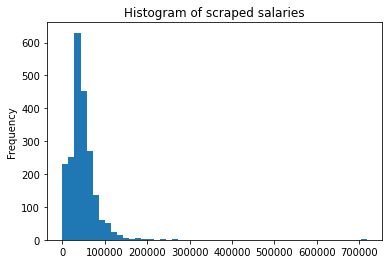

In [16]:
#Plot quick histogram of salaries 
jobs.salary.plot(kind='hist', bins=50,title='Histogram of scraped salaries');

## Write clean results to CSV

In [17]:
jobs.to_csv('combined_jobs.csv', index=False, header=jobs.columns )

## Read in the cleaned jobs CSV

In [18]:
jobs = pd.read_csv('combined_jobs.csv', index_col=None, header=0)

# A little further cleaning to remove spaces in data
jobs['search_role']=[x.replace(' ','_') for x in jobs['search_role']]

## We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

*We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.*

*While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the median as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point. In this project however, we will split at the median value.*

In [19]:
# Drop jobs with salary < 2000 per year - these must be erroneous
jobs = jobs[jobs['salary']>2000]

# Define target binary variable
print('Salary median',jobs.salary.median())
print('Salary mean',jobs.salary.mean())
jobs['above_median'] = [1 if x > jobs.salary.median() else 0 for x in jobs.salary]

Salary median 45000.0
Salary mean 50184.97963636364


## Observe the baseline accuracy for our model?

In [20]:
# Baseline accuracy is just the proportion of the largest class
jobs.above_median.value_counts(normalize=True).max()

0.5267676767676768

## Remove some salary outliers

In [21]:
# Define a printing in bold function definition - for nice summary stats

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

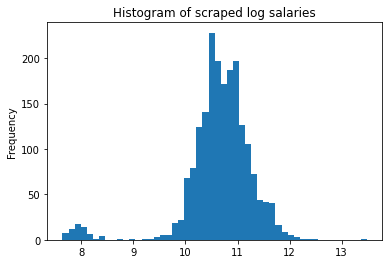

In [22]:
# Plot histogram of log salaries - this is for outlier analysis 
jobs['log_salary'] = [np.log(x) for x in jobs.salary]
jobs.log_salary.plot(kind='hist', bins=50,title='Histogram of scraped log salaries', xlabel='Log of salary');

DataFrame shape before dropping outliers (1980, 11)
DataFrame shape after dropping outliers (1917, 11)


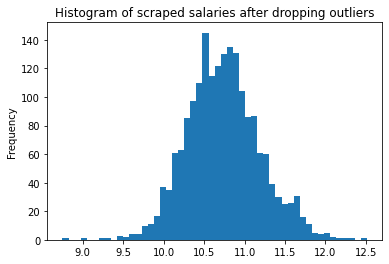

In [23]:
#Plot histogram of log salaries after dropping outliers
mask = np.abs((jobs.log_salary - jobs.log_salary.mean(0)) / jobs.log_salary.std(0)) > 3
print('DataFrame shape before dropping outliers',jobs.shape)
jobs= jobs[~mask]
print('DataFrame shape after dropping outliers',jobs.shape)
jobs.log_salary.plot(kind='hist', bins=50,title='Histogram of scraped salaries after dropping outliers');

*Interestingly I don't think that it was really necessary for me to take the log of the salaries here as Logistic Regression does not make any assumptions of linearity between variables. However it certainly looks a little nicer this way and it is more robust for me to remove outliers from a normally distributed dataset rather than one with significant skew.*

## High level EDA

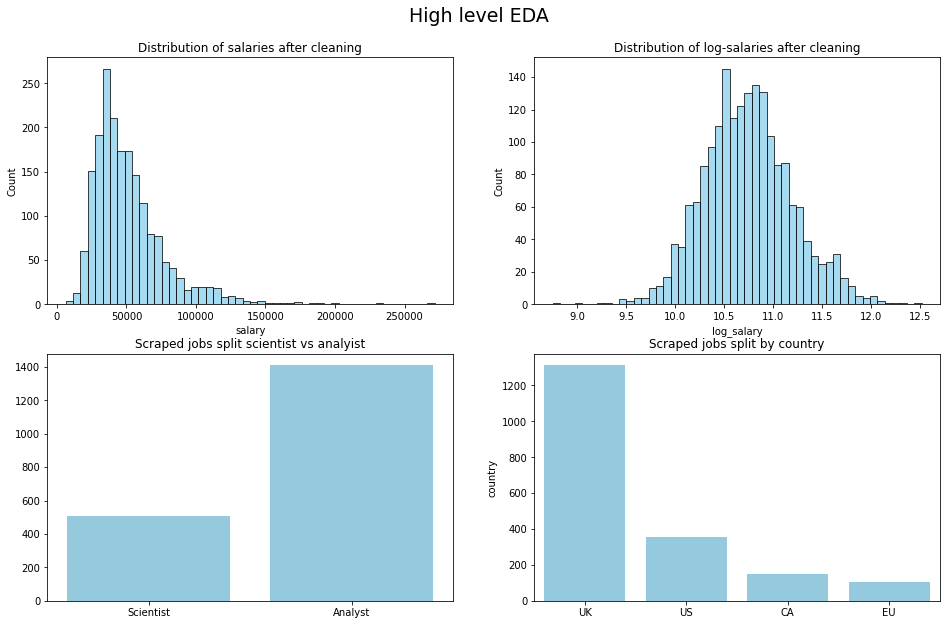

In [24]:
# High level EDA plot for the report! This is the data going into modeling.
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,10))
sns.histplot(data = jobs.log_salary, ax=ax[0,1], bins=50,color='skyblue')
sns.histplot(data = jobs.salary, ax=ax[0,0], bins=50,color='skyblue')
sns.barplot(x=['Scientist','Analyst'], y=[jobs.search_role.value_counts()[1],jobs.search_role.value_counts()[0]], ax=ax[1,0],color='skyblue')
sns.barplot(x=pd.DataFrame(jobs.country.value_counts()).index, y=pd.DataFrame(jobs.country.value_counts()).country, ax=ax[1,1],color='skyblue')
ax[0,0].set_title('Distribution of salaries after cleaning')
ax[0,1].set_title('Distribution of log-salaries after cleaning')
ax[1,0].set_title('Scraped jobs split scientist vs analyist')
ax[1,1].set_title('Scraped jobs split by country')
plt.suptitle('High level EDA', fontsize=19, y=0.95)
plt.show()

## Create a classification model to predict High/Low salary. 

In [25]:
# Import libraries and classifiers I'll need 

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


*This is where some of the NLP starts. I'm going to use the nltk library to identify commonly occurring patterns in the job 'title' data.*

*I use a PorterStemmer to stem the words in job 'title' before using CountVectorizer to convert the text data to numerical occurrences of the top 40 stemmed words. Some tailored stop words have been applied and n-grams are limited to one word in length. I did test n-grams up to length three but ultimately they didn't improve model accuracy, so we proceed with one.*

In [26]:
# Stemming and CountVectorizing the jobs.title column to obtain top 40 occuring words in a dataframe 
stemmer = PorterStemmer()
jobs['title']=['no_title' if str(x) == 'nan' else str(x) for x in jobs['title']]
jobs['title']=[stemmer.stem(x) for x in jobs['title']]
#jobs['search_role']=[x.replace(' ','_') for x in jobs['search_role']]
stop = stopwords.words('english')
stop += ['no_titl','na']
cvec = CountVectorizer(stop_words=stop, max_features=40,   ngram_range=(1, 1))
cvec.fit(jobs.title)
vec_title = pd.DataFrame(cvec.transform(jobs.title).toarray(),columns=cvec.get_feature_names())

/Users/robertdavies/opt/anaconda3/envs/salaries_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
# Plot of most common occuring words
words= cvec.get_feature_names()
document_matrix = cvec.transform(jobs.title) 
b = document_matrix.sum(axis=0)
c1 = pd.DataFrame(b, columns=words).transpose().sort_values(by=0, ascending=False)[:20]
c1.columns = ['Occurrence count']
c1.T

/Users/robertdavies/opt/anaconda3/envs/salaries_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,analyst,data,business,senior,scientist,bi,machine,learning,intelligence,research,engin,analytics,lead,develop,risk,systems,engineer,reporting,insight,science
Occurrence count,1069,710,355,256,254,114,79,78,76,60,53,52,51,49,48,47,46,38,38,37


*This is the output from NLP that I'm going to join with the other predictors.*

*In the cell below we perform a train-test split, join the NLP data with the existing jobs dataset  and drop some columns which haven't proved to be beneficial to modelling.*

In [28]:
# Train test split
jobs.reset_index(inplace=True,drop=True)
jobs.country = [x if str(x) != 'EU' else 'FR_DE' for x in jobs.country]
X = jobs.join(vec_title)
X = X.drop(labels=['salary','location','employer'
                     ,'title','summary','employer_rating',
                    'above_median','log_salary']
                    ,axis=1)
X = pd.get_dummies(X,columns =['search_city','country','search_role'] ,drop_first=True)
y = jobs['above_median']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1, stratify= y)

In [ ]:
# Define, fit and evaluate a elastic net logistic regression classifier. Hyperparameters optimised.

sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test),columns = X_test.columns)

log_reg_params = {
    'penalty':  ['elasticnet'],
    'C': np.logspace(-4, 4, 20),
    'l1_ratio': np.linspace(0.00001,1,10),
    'solver': ['saga'],
    'max_iter':[5000]}

lr_base = LogisticRegression()
lr = GridSearchCV(lr_base, 
                     log_reg_params, 
                     n_jobs=2
                     ,cv=5)
lr.fit(X_train, y_train);

In [ ]:
# Print success metrics
printmd('**Elastic Net logistic regression classifier with multiple predictors and optimised hyperparameters**')
print('Baseline accuracy:',y.value_counts(normalize=True).max())
print('Train accuracy score: ',lr.best_estimator_.score(X_train, y_train))
cvscore = cross_val_score(lr.best_estimator_, X_train, y_train, cv=5)
print('Cross val accuracy: ',cvscore)
print('Mean cross val accuracy score: ',cvscore.mean())
print('Test accuracy:',lr.best_estimator_.score(X_test, y_test))
print('\nThe optimum Hyperparameters are printed below. Note that any parameters not included will be default: \n',lr.best_estimator_)

In [ ]:
# Evaluate coefficients

# Define function to help interpret logistic regression results
def logit2prob(logit_coef):
    odds = np.exp(logit_coef)
    prob = odds / (1 + odds)
    return(prob)


# Coefficients to df and plot
lr_coefs = pd.DataFrame({'coef': lr.best_estimator_.coef_[0],
                            'abs_coef': np.abs(lr.best_estimator_.coef_[0]),
                            'std_dev': np.std(X_train),
                            'Impact on odds of being an high paying job': np.exp(lr.best_estimator_.coef_[0]),
                            'Probability of being an high paying job': np.exp(lr.best_estimator_.coef_[0])/(1+np.exp(lr.best_estimator_.coef_[0]))})
lr_coefs.sort_values('abs_coef', inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(5, 5))
lr_coefs.iloc[:10,0].plot(kind='barh', ax=ax, alpha=0.5, title='Logistic regression coefficients')
ax.set_yticklabels(lr_coefs.index[:10].values)
plt.gca().invert_yaxis()
plt.show()
lr_coefs.head(10)

*Using the logistic regression classifier we obtain predictor coefficients which can allow for interpretation of both how influential the predictor was and whether it had a positive or negative influence on the probability of the target variable (salary high/low) being 1 (high) or 0 (low).*
    
* *In terms of odds, an increase in 1 standard deviation of the search_role_data_scientist variable multiplies the odds of a high salary by 1.43. This is a positive predictor.*
* *In terms of probability, a job with search_role_data_scientist = 1 impacts the probability of it being a high salary job by 0.59. Approximately 3 in 5 search_role_data_scientist jobs are classified as high salary.*


* *In terms of odds, an increase in 1 standard deviation of the country_UK variable multiplies the odds of a high salary by 0.71. This is a negative predictor.*
* *In terms of probability, a job with country_UK = 1 impacts the probability of it being a high salary job by 0.41. Approximately 2 in 5 country_UK jobs are classified as high salary.*


## Evaluating the model

In [ ]:
# Confusion matrix on test data for Elastic Net lr model
 
fig, ax = plt.subplots( ncols=2 ,figsize=(12, 4), sharey=True)
plot_confusion_matrix(lr.best_estimator_, X_test, y_test, cmap='Blues', ax=ax[0])
plot_confusion_matrix(lr.best_estimator_, X_test, y_test, cmap='Blues', ax=ax[1], normalize='all')
ax[0].set_title('Test Data Confusion Matrix')
ax[1].set_title('Test Data Normalised Confusion Matrix')
ax[0].xaxis.set_ticklabels(['0 - low salary', '1 - high salary']); ax[0].yaxis.set_ticklabels(['0 - low salary', '1 - high salary']);
ax[1].xaxis.set_ticklabels(['0 - low salary', '1 - high salary']); ax[1].yaxis.set_ticklabels(['0 - low salary', '1 - high salary']);

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(16)

plt.show()

*With a threshold of 0.5 as default, the Elastic Net lr model yields...* 
* *A ~11% False Negative rate. That is 11% of high paying jobs are wrongly predicted to be low paying jobs.*
* *A ~9.6% False Positive rate. That is 9.6% of low paying jobs are wrongly predicted to be high paying jobs.*
* *~79% of jobs are correctly predicted to be low or high paying.* 

In [ ]:
# Evaluating the AUR-ROC curve and precision-recall plot of Elastic Net lr model 
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 6))

fig, ax = plt.subplots(ncols=2,figsize=(16,7))
skplt.metrics.plot_precision_recall(y_test, lr.best_estimator_.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=16, text_fontsize=8, cmap=cmap, ax=ax[0])
skplt.metrics.plot_roc(y_test, lr.best_estimator_.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=16, text_fontsize=8, cmap=cmap, ax=ax[1])
plt.show()
ax[0].legend(loc=[0.01, 0.01])
ax[1].legend(loc=[0.01, 0.01])

plt.show()

*The precision-recall curve displays the relationship between the two attributes for each of the classes (1 is high paying job and 0 is a low paying job. In an ideal world we would obtain simultaneously high precision and recall, but often that's not possible.*

*Precision of a class is defined to be TP/(TP+FP). It follows that Precision should increase as the FP rate decreases.*
*Recall of a class is defined to be TP/(TP+FN). It follows that as Recall should increase as the FN rate decreases.*

*The ROC curve for each class helps image how much better the model is performing than the baseline for a range of threshold values. An optimal False Positive Rate (FPR) and corresponding True Positive Rate (TPR) can be determined from the plot based on the business case in question.*

*Reverting to the original question, it has been stressed that I should explain the model results in detail, as well as explain the tradeoffs between detecting high vs low salary positions. For this, I find the plots below more useful. In order to explain the model to my manager I would make specific reference to the threshold vs normalised FN, FP, TN and TP on the right.*

In [ ]:
# Define some functions to help, then plot different scores at different thresholds
def predict_at_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0

def scores_at_thresholds(probs, test_data):
    predictions = [probs.apply(predict_at_threshold, threshold=i) for i in np.linspace(0, 1, 100)]
    scores = np.array(
    [(threshold, 
      accuracy_score(test_data, predictions[i]),
      precision_score(test_data, predictions[i],zero_division=1),
      recall_score(test_data, predictions[i]), 
      f1_score(test_data, predictions[i]),
      confusion_matrix(test_data,predictions[i], normalize='all')[1,0],
      confusion_matrix(test_data,predictions[i], normalize='all')[0,1],
      confusion_matrix(test_data,predictions[i], normalize='all')[0,0],
      confusion_matrix(test_data,predictions[i], normalize='all')[1,1]) 
      
     for i, threshold in enumerate(np.linspace(0, 1, 100))])
    return scores

Y_pp = pd.DataFrame(lr.best_estimator_.predict_proba(X_test), 
             columns=['class_0_predicted_probability_LoSal', 'class_1_predicted_probability_HiSal'])

scores = scores_at_thresholds(Y_pp.class_1_predicted_probability_HiSal, y_test);

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,7))

# Plot data
ax1.plot(scores[:, 0], scores[:, 1], label='accuracy')
ax1.plot(scores[:, 0], scores[:, 2], label='precision')
ax1.plot(scores[:, 0], scores[:, 3], label='recall')
ax1.plot(scores[:, 0], scores[:, 4], label='f1')
ax2.plot(scores[:, 0], scores[:, 5], label='FN')
ax2.plot(scores[:, 0], scores[:, 6], label='FP')
ax2.plot(scores[:, 0], scores[:, 7], label='TN')
ax2.plot(scores[:, 0], scores[:, 8], label='TP')

# Adjust legends, titles and labels
ax1.legend(loc=[0.01, 0.01])
ax1.set_xlabel('Threshold')
ax1.set_title('Threshold vs Accuracy, Precision, Recall and F1 for High Salary Predictions')
ax2.legend(loc=[0.01, 0.45])
ax2.set_xlabel('Threshold')
ax2.set_title('Threshold vs Normalised FN, FP, TN and TP for High Salary Predictions')

# Annotations
circle_rad = 15  # This is the radius, in points
point=[0.78,0.70]
ax1.plot(point[0], point[1], 'o', ms=circle_rad * 1, mec='black', mfc='none', mew=1)
ax1.annotate('70% Accuracy% at Threshold 0.78', xy=point, xytext=(-170, 100),
            textcoords='offset points',
            color='black', size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.1,head_width=0.5,head_length=0.5',
                facecolor='black', shrinkB=circle_rad * 1))

point=[0.78,0.025]
ax2.plot(point[0], point[1], 'o', ms=circle_rad * 1, mec='black', mfc='none', mew=1)
ax2.annotate('FP=2.5% at Threshold 0.78', xy=point, xytext=(-90, 60),
            textcoords='offset points',
            color='black', size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.1,head_width=0.5,head_length=0.5',
                facecolor='black', shrinkB=circle_rad * 1))

plt.show();

*Focusing on the right hand plot, the FN number is the normalised number of high paying jobs which are wrongly predicted to be low paying jobs and the FP number is the normalised number low paying jobs which are wrongly predicted to be high paying jobs. We observe how varying the prediction threshold between 0 and 1 can alter the FP and FN statistics.*

*Because my boss would rather tell a client incorrectly that they would get a lower salary job (FN) than tell a client incorrectly that they would get a high salary job (FP), I suggest that they consider the three circled 'sweet spot' on the right and the associated impact on overall accuracy on the left. The boss' request could be interpreted as wanting to minimise the FP rate for class 1 (above median salary) or as wanting to maximise the accuracy of class 1 (above median salary), these two are equivalent. Once they understand, it is then down to my boss to decide which threshold and corresponding FP/FN/Accuracy statistic would be acceptable for the company.*

*Assuming the boss elects a threshold of 0.78, the model yields the following statistics.*

In [ ]:
# Printing lr model classification report with threshold 0.78
Y_pp['pred_class_thresh'] = Y_pp.class_1_predicted_probability_HiSal.apply(predict_at_threshold, 
                                                threshold=0.78)
print(classification_report(y_test, Y_pp.pred_class_thresh))

*This concludes the Jupyter Notebook. Most of this has been included in the readme file for this project.*